### projection model => project points per player  
- [x]    Stats  
- [ ]    Usage  
- [ ]    Percentage of team scoring  
- [x]    Injuries  
- [x]    Bye week
- [ ]    Injuries to Key Teammates / Individual Matchups
- [x]    Opposing Team (record, defense, injuries, etc.)
- [x]    Home/Away
- [ ]    Weather
- [ ]    Expert Picks
- [ ]    Other Fantasy Projections

### selection mechanism => maximize value (pts/salary)
- [x]    Linear Optimization
    - Inspiration: https://github.com/breeko/Fantasy_LP/blob/master/fantasy_lp_final.ipynb

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def format_stats(df):
    df = df.dropna()
    df = df[df['Week'] != 'Week']  # remove 'filler' rows
    # update historical teams
    m = {'oak':'lvr', 'sdg':'lac', 'stl':'lar'}
    df.replace({'Oppt': m, 'Team': m}, inplace=True)
    df = df[(df.Oppt != '-') & (df.Pos != 'PK')]
    df = df.astype({'Week':int, 'Year':int, 'GID':int, 'Name':'string', 'Pos':'string', 'Team':'string',
                    'h/a':'string', 'Oppt':'string', 'FD points':float, 'FD salary':int})
    return df.rename(columns={'FD points': 'Points', 'FD salary': 'Salary'})

In [4]:
def add_averages(df):
    df.sort_values(['Year','Week'], inplace=True)
    df['prev_pts'] = df.groupby(['Year','GID'])['Points'].shift() #.fillna(0.0)
    df['avg_pts'] = df.groupby(['Year','GID'])['prev_pts'].transform(lambda x: x.expanding(3).mean())
    df['pts_std'] = df.groupby(['Year','GID'])['prev_pts'].transform(lambda x: x.expanding(3).std())
#     df['last3_avg'] = df.groupby(['Year','GID'])['prev_pts'].transform(lambda x: x.rolling(3,3).mean())
    df['ewm5'] = df.groupby(['Year','GID'])['prev_pts'].transform(lambda x: x.ewm(span=5, min_periods=3).mean())
    df['avg_rank'] = df.groupby(['Year','Week','Pos'])['avg_pts'].rank("dense", ascending=False, na_option='bottom')
    df['prev_rank'] = df.groupby(['Year','Week','Pos'])['prev_pts'].rank("dense", ascending=False, na_option='bottom')
    return df

In [5]:
# fix name differences over time
def use_most_recent_name(df):
    newest_names = df.groupby('GID').agg({'Name':'last'}).astype('string')
    df = df.set_index('GID')
    df.update(newest_names)
    return df.astype({'Name':'string'}).reset_index()

In [6]:
def opp_pos_norm(df):
    o = df.groupby(['Year','Week','Oppt','Pos']).agg({'Points': 'sum'})
    o['prev_pts'] = o.groupby(['Year','Oppt','Pos'])['Points'].shift() #.fillna(0.0)
    o['running_avg'] = o.groupby(['Year','Oppt','Pos'])['prev_pts'].transform(lambda x: x.expanding().mean())
    o['running_league_avg'] = o.groupby(['Year','Week','Pos'])['running_avg'].transform('mean')
    o['running_league_std'] = o.groupby(['Year','Week','Pos'])['running_avg'].transform('std')
    o['norm'] = (o['running_avg']-o['running_league_avg'])/o['running_league_std']
    ndf = df.join(o[['norm']], on=['Year','Week','Oppt','Pos'], how='left')
    return ndf.astype({'Pos':'string', 'Oppt':'string'})

In [7]:
def points_adjusted(df, col, mult_factor=2):
    df['Pts Adjusted'] = df[col] + (mult_factor*df['norm'])
    return df

In [ ]:
# def remove_potential_injuries(df):
#     df['inj'] = df.groupby(['Year','GID'])['Points'].transform(lambda x: x.shift(-1)==0.0)
#     return df[~df.inj].drop('inj', axis=1)

In [8]:
def add_gp_and_season_totals(df):
    df['gp'] = df.groupby(['Year','GID'])['Points'].transform(lambda x: x.shift()>0.0)
    df['gp'] = df.groupby(['Year','GID'])['gp'].transform(lambda x: x.expanding().sum())
    df['season_points'] = df.groupby(['Year','GID'])['Points'].transform(lambda x: x.shift().expanding().sum())
    return df

In [9]:
def enrich_df(res):
    res = res.copy()
    res = add_averages(res)
    res = opp_pos_norm(res)
#     res = remove_potential_injuries(res)
    res = add_gp_and_season_totals(res)
    res = res[res.Week > 4]
    res = use_most_recent_name(res)
    res = res.fillna(0.0)
    res = points_adjusted(res, 'ewm5', mult_factor=1.5)
    return res

## Historical DF

In [ ]:
# # last 10 years
# for year in range(2010,2021):
#     f = open(f"historical_fantasy_data/{year}_fantasy_points.txt", "w", newline='')
#     for week in range(1,18):
#         url = "http://rotoguru1.com/cgi-bin/fyday.pl?week="+str(week)+"&game=fd&year="+str(year)+"&scsv=1"
#         r = requests.get(url)
#         soup = BeautifulSoup(r.content, 'html.parser')
#         data = soup.find_all('pre')[-1]
#         f.write(data.text)
#     f.close()

In [12]:
# enrich and combine into one dataframe
def historical_df():
    res = pd.DataFrame()
    for year in range(2010,2021):
        df = format_stats(pd.read_csv(f"historical_fantasy_data/{year}_fantasy_points.txt", delimiter=';'))
        res = res.append(df)
    return res

In [13]:
res = historical_df()
rdf = enrich_df(res)
rdf

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted
0,1232,5,2011,"Roethlisberger, Ben",QB,pit,h,ten,28.12,7800,8.34,12.305000,4.206166,11.841538,22.0,23.0,-1.216577,4.0,49.22,10.016673
1,1241,5,2011,"Cassel, Matt",QB,kan,a,ind,27.48,7500,16.40,9.680000,7.210455,11.754462,24.0,18.0,-0.265659,4.0,38.72,11.355973
2,1155,5,2011,"Vick, Michael",QB,phi,a,buf,25.60,9600,31.14,19.660000,9.572906,21.121538,6.0,3.0,1.467186,4.0,78.64,23.322317
3,1378,5,2011,"Newton, Cam",QB,car,h,nor,24.66,8500,33.46,27.435000,8.427216,27.418154,3.0,2.0,0.327539,4.0,109.74,27.909462
4,1225,5,2011,"Manning, Eli",QB,nyg,h,sea,24.30,8300,18.54,18.760000,4.994851,19.539385,8.0,10.0,-0.394480,4.0,75.04,18.947665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51102,7011,17,2020,Detroit,Def,det,h,min,-1.00,3400,4.00,2.400000,3.112188,2.003185,28.0,9.0,0.664761,9.0,36.00,3.000326
51103,7015,17,2020,Kansas City,Def,kan,h,lac,-1.00,4200,7.00,7.333333,7.016986,6.604938,7.0,6.0,0.294807,14.0,110.00,7.047149
51104,7002,17,2020,Atlanta,Def,atl,a,tam,-1.00,3300,5.00,4.866667,6.801961,5.482783,19.0,8.0,-0.753396,12.0,73.00,4.352689
51105,7006,17,2020,Chicago,Def,chi,h,gnb,-1.00,4100,6.00,6.200000,5.414267,6.656157,14.0,7.0,-1.709110,14.0,93.00,4.092492


In [14]:
# check for null values
rdf[rdf.isna().any(axis=1)]

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted


## Encode Categorical Variables

In [10]:
# numerical encoding for categorical variables
def encode_cats(res):
    res = res.copy()
    team_idx = {p:i for i,p in enumerate(sorted(res.Team.unique()))}
    pos_idx = {p:i for i,p in enumerate(sorted(res.Pos.unique()))}
    res.replace({'h/a': {'h': 1, 'a': 0}, 'Pos': pos_idx, 'Team': team_idx, 'Oppt': team_idx}, inplace=True)
    return res

In [15]:
tdf = encode_cats(rdf)

In [16]:
# null value check per column
tdf.isna().any()

GID              False
Week             False
Year             False
Name             False
Pos              False
Team             False
h/a              False
Oppt             False
Points           False
Salary           False
prev_pts         False
avg_pts          False
pts_std          False
ewm5             False
avg_rank         False
prev_rank        False
norm             False
gp               False
season_points    False
Pts Adjusted     False
dtype: bool

In [ ]:
# res['Year'] = pd.Categorical(res['Year'])
# res['Week'] = pd.Categorical(res['Week'])
# res['GID'] = pd.Categorical(res['GID'])
# res['Team'] = pd.Categorical(res['Team'])
# res['h/a'] = pd.Categorical(res['h/a'])
# res['Oppt'] = pd.Categorical(res['Oppt'])
# res['Pos'] = pd.Categorical(res['Pos'])

### Plot Skewness

In [17]:
import seaborn as sns
from scipy import stats

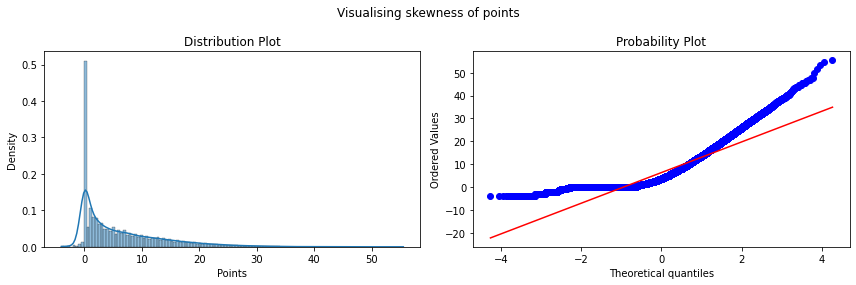

<Figure size 432x288 with 0 Axes>

In [18]:
# Figure
plt.figure(figsize=(12, 4))
plt.suptitle("Visualising skewness of points")

# Distribution Plot
plt.subplot(1, 2, 1)
sns.histplot(res["Points"], stat = "density", kde = True)
plt.title('Distribution Plot')

# Probability Plot
plt.subplot(1, 2, 2)
stats.probplot(res['Points'], plot=plt)

plt.tight_layout()
plt.show()
plt.clf()

## Regression Model Comparison

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error#, mean_squared_log_error as MSLE

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, \
                             ExtraTreesRegressor, GradientBoostingRegressor

from xgboost import XGBRegressor

SEED = 42

In [19]:
tdf = tdf.set_index('Name')

y = tdf.Points
X = tdf.drop(['Points'], axis=1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.20)

In [20]:
# current heuristic
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, test_X['Pts Adjusted']))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, test_X['Pts Adjusted']))

Mean Absolute Error using Decision Tress : 4.2027268392573705
Mean Squared Error using Decision Tress : 35.11616997663873


In [21]:
model = DecisionTreeRegressor(criterion='mse')  
model.fit(train_X, train_y) 
preds = model.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 5.453920954803365
Mean Squared Error using Decision Tress : 63.04374537272549


In [23]:
# feature importance in descending order of importance
feat_importance = {col: imp for col,imp in zip(test_X.columns, model.feature_importances_)}
dict(sorted(feat_importance.items(), key=lambda item: item[1], reverse=True))

{'Salary': 0.3253405612069918,
 'avg_pts': 0.16477843838748796,
 'norm': 0.04665030933978924,
 'pts_std': 0.04653234286976557,
 'GID': 0.0458684319658675,
 'season_points': 0.04388327497472463,
 'prev_pts': 0.04349299114055488,
 'ewm5': 0.042613082441813124,
 'Pts Adjusted': 0.04119148946234238,
 'Oppt': 0.03589881548695797,
 'Team': 0.032380656336022745,
 'avg_rank': 0.03225193180167384,
 'prev_rank': 0.03204860240718213,
 'Year': 0.019892854517015463,
 'Week': 0.01967957627338138,
 'gp': 0.013081212575479562,
 'Pos': 0.008937282338161103,
 'h/a': 0.00547814647478879}

In [24]:
model = RandomForestRegressor(criterion='mse')  
model.fit(train_X, train_y) 
preds = model.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.9672718450401097
Mean Squared Error using Decision Tress : 30.799801831062418


In [66]:
# Only Imp Feats
model = RandomForestRegressor(criterion='mse')  
model.fit(train_X, train_y) 
preds = model.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.9499088045392288
Mean Squared Error using Decision Tress : 30.320428562758753


In [67]:
feat_importance = {col: imp for col,imp in zip(test_X.columns, model.feature_importances_)}
feat_importance

{'GID': 0.08669241900429432,
 'Salary': 0.27739472636389734,
 'prev_pts': 0.07393348051399191,
 'avg_pts': 0.21744934257092455,
 'pts_std': 0.07873289599756898,
 'ewm5': 0.10022417996242758,
 'norm': 0.07760390047039901,
 'Pts Adjusted': 0.08796905511649634}

In [25]:
# Ridge Regression (L2 Regularization)
ridge = RidgeCV(normalize=False)
ridge.fit(train_X, train_y)
best_alpha = ridge.alpha_
print(best_alpha)
preds = ridge.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

10.0
Mean Absolute Error using Decision Tress : 4.017866388921465
Mean Squared Error using Decision Tress : 31.00684276800927


In [26]:
# Lasso Regression (L1 Regularization)
lasso = LassoCV(alphas=None, max_iter=100000, normalize=True)
lasso.fit(train_X, train_y)
best_alpha = lasso.alpha_
print(best_alpha)
preds = lasso.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

2.290898889220244e-05
Mean Absolute Error using Decision Tress : 4.019020331761902
Mean Squared Error using Decision Tress : 31.007032357746905


In [27]:
forest = RandomForestRegressor(random_state = SEED)
forest.fit(train_X, train_y)
preds = forest.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.9638895715124236
Mean Squared Error using Decision Tress : 30.816456428792797


In [28]:
ada = AdaBoostRegressor(random_state = SEED)
ada.fit(train_X, train_y)
preds = ada.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 5.754626484666327
Mean Squared Error using Decision Tress : 45.87490648817818


In [29]:
bagging = BaggingRegressor(random_state = SEED)
bagging.fit(train_X, train_y)
preds = bagging.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 4.149222852670709
Mean Squared Error using Decision Tress : 33.70366945724907


In [30]:
ETR = ExtraTreesRegressor(random_state = SEED)
ETR.fit(train_X, train_y)
preds = ETR.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.969273429857171
Mean Squared Error using Decision Tress : 30.818621430941114


In [86]:
GBR = GradientBoostingRegressor(random_state = SEED)
GBR.fit(train_X, train_y)
preds = GBR.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.8428768582090345
Mean Squared Error using Decision Tress : 29.371090708613796


In [80]:
XGB = XGBRegressor(random_state = SEED)
XGB.fit(train_X, train_y)
preds = XGB.predict(test_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(test_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(test_y, preds))

Mean Absolute Error using Decision Tress : 3.864580542043452
Mean Squared Error using Decision Tress : 30.434276268944544


## This Year

In [11]:
from bs4 import BeautifulSoup
import requests

In [10]:
year = 2021

In [12]:
f = open(f"2021_fantasy_data/{year}_fantasy_points.txt", "w", newline='')
for week in range(1,19):
    url = "http://rotoguru1.com/cgi-bin/fyday.pl?week="+str(week)+"&game=fd&year="+str(year)+"&scsv=1"
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    data = soup.find_all('pre')[-1]
    f.write(data.text)
f.close()

In [11]:
year_df = format_stats(pd.read_csv(f"2021_fantasy_data/{year}_fantasy_points.txt", delimiter=';'))
year_df

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,Salary
0,1,2021,1537,"Murray, Kyler",QB,ari,a,ten,34.56,8400
1,1,2021,1523,"Mahomes II, Patrick",QB,kan,h,cle,33.28,8800
2,1,2021,1490,"Goff, Jared",QB,det,h,sfo,29.92,6500
3,1,2021,1465,"Winston, Jameis",QB,nor,h,gnb,29.62,6700
4,1,2021,1131,"Brady, Tom",QB,tam,h,dal,29.16,7800
...,...,...,...,...,...,...,...,...,...,...
8037,18,2021,7002,Atlanta,Def,atl,h,nor,0.00,3300
8038,18,2021,7026,LA Chargers,Def,lac,a,lvr,-1.00,4200
8039,18,2021,7023,Philadelphia,Def,phi,h,dal,-3.00,3700
8040,18,2021,7005,Carolina,Def,car,a,tam,-3.00,3400


### Test historical regression predictions on this year's data

In [354]:
ydf = encode_cats(enrich_df(year_df))

tst_y = ydf.Points
tst_X = ydf.drop(['Points'], axis=1).set_index('Name')

In [355]:
# current heuristic
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(tst_y, tst_X['Pts Adjusted']))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(tst_y, tst_X['Pts Adjusted']))

Mean Absolute Error using Decision Tress : 4.194664500279587
Mean Squared Error using Decision Tress : 34.22182014092551


In [356]:
# Gradient Boosting Regression
preds = GBR.predict(tst_X)
print ("Mean Absolute Error using Decision Tress :", mean_absolute_error(tst_y, preds))
print ("Mean Squared Error using Decision Tress :", mean_squared_error(tst_y, preds))

Mean Absolute Error using Decision Tress : 3.8960175521083538
Mean Squared Error using Decision Tress : 29.02786616611834


## Re-train regression on all data

In [357]:
full = res.append(year_df)
full = full.sort_values(['Year','Week']).reset_index()
full

,index,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,Salary
0,0,1,2011,1131,"Brady, Tom",QB,nwe,a,mia,35.98,9200
1,1,1,2011,1309,"Henne, Chad",QB,mia,h,nwe,35.54,6800
2,2,1,2011,1378,"Newton, Cam",QB,car,a,ari,31.68,6700
3,3,1,2011,1151,"Brees, Drew",QB,nor,a,gnb,29.06,8900
4,4,1,2011,1242,"Fitzpatrick, Ryan",QB,buf,a,kan,24.62,7900
...,...,...,...,...,...,...,...,...,...,...,...
72243,4874,11,2021,7031,Washington,Def,was,a,car,1.00,3500
72244,4875,11,2021,7017,Minnesota,Def,min,h,gnb,1.00,3400
72245,4876,11,2021,7030,Tennessee,Def,ten,h,hou,0.00,4600
72246,4877,11,2021,7026,LA Chargers,Def,lac,h,pit,-1.00,4200


In [354]:
fdf = encode_cats(enrich_df(year_df))

full_y = fdf.Points
full_X = fdf.drop(['Points'], axis=1).set_index('Name')

In [355]:
# train GBR on full training set
GBR = GradientBoostingRegressor(random_state = SEED)
GBR.fit(full_X, full_y)

GradientBoostingRegressor(random_state=42)

# Upcoming week

## Download and Format data

In [15]:
# wk = max(year_df.Week)+1
wk = 18
wk

18

In [18]:
# !pip install selenium
# download chrome driver from: https://chromedriver.chromium.org/home
# unzip chromedriver.zip
# $ mv <Path>/chromedriver /usr/local/bin/.
# $ xattr -d com.apple.quarantine /usr/local/bin/chromedriver 

In [15]:
from selenium import webdriver

In [16]:
driver = webdriver.Chrome()
driver.get("https://www.dailyfantasycafe.com/tools/salary-exploitation/nfl")
elem = driver.find_element('id', "DataTables_Table_0")
week_df = pd.read_html(elem.get_attribute('outerHTML'))[0]
driver.close()

In [17]:
week_df

,Name,Position,Team,Opponent Opp,DraftKings,FanDuel,Yahoo
0,A.J. Brown,WR,TEN,@HOU,"$7,000","$7,400",$29
1,A.J. Green,WR,ARI,SEA,"$5,400","$5,700",$15
2,Aaron Fuller,WR,SEA,@ARI,"$3,000","$4,500",-
3,Aaron Jones,RB,GB,@DET,"$7,300","$7,300",$29
4,Aaron Rodgers,QB,GB,@DET,"$7,800","$8,200",$35
...,...,...,...,...,...,...,...
714,Zach Gentry,TE,PIT,@BAL,"$2,900","$4,400",$10
715,Zach Pascal,WR,IND,@JAX,"$3,300","$5,200",$11
716,Zach Wilson,QB,NYJ,@BUF,"$5,200","$6,500",$20
717,Zack Moss,RB,BUF,NYJ,"$5,000","$5,300",$15


In [12]:
def format_salary_df(df):
    df = df[df.FanDuel!='-']
    df = df[df.Position.isin(['QB','WR','RB','TE','D'])]
    df = df.rename(columns={'Position':'Pos', 'Opponent  Opp':'Oppt'})
    df.loc[df.Pos=='D', 'Pos'] = 'Def'
    df['Salary'] = df['FanDuel'].str.replace('[\$,]', '', regex=True).astype(int)
    return df[['Name','Pos','Team','Oppt','Salary']]

def last_name_first(df):
    s = df[df['Pos']!='Def']['Name']
    s = s.str.split(' ', expand=True).fillna('')
    s['last_name'] = s.iloc[:, 1:].agg(' '.join, axis=1).str.strip()
    s['join_name'] = s[['last_name',0]].agg(', '.join, axis=1)
    df.loc[df.Pos!='Def', 'Name'] = s.join_name
    return df

def add_home_away_update_team_names(df):
    team_names = {'gb':'gnb','jax':'jac','kc':'kan','lv':'lvr','ne':'nwe','no':'nor','sf':'sfo','tb':'tam'}
    df['h/a'] = df['Oppt'].apply(lambda x: 'a' if '@' in x else 'h')
    df['Oppt'] = df.Oppt.str.replace('@','').str.lower().replace(team_names)
    df['Team'] = df.Team.str.lower().replace(team_names)
    return df

def add_GIDs(salary, df):    
    d = df[df.Pos=='Def'].groupby(['GID'], as_index=False).agg('last')
    s = salary[salary.Pos=='Def'].drop(columns=['Name']).copy()
    s = s.join(d[['GID','Team','Name']].set_index('Team'), on='Team', how='inner')

    d = df[df.Pos!='Def'].groupby(['GID'], as_index=False).agg('last')
    p = salary[salary.Pos!='Def'].copy()
    p = p.join(d[['GID','Name']].set_index('Name'), on='Name', how='inner')
    return pd.concat([p,s])

def reformat_next_week_df(week_df, year_df, week, year='2021'):
    df = week_df.copy()
    df = format_salary_df(df)
    df = last_name_first(df)
    df = add_home_away_update_team_names(df)
    df = add_GIDs(df, year_df)
    df['Week'] = week
    df['Year'] = year
    df['Points'] = 0.0
    df = df.astype({'Week':int, 'Year':int, 'GID':int, 'Name':'string', 'Pos':'string', 'Team':'string',
                    'h/a':'string', 'Oppt':'string', 'Points':float, 'Salary':int})
    return df[['Week','Year','GID','Name','Pos','Team','h/a','Oppt','Points','Salary']]

In [19]:
wdf = reformat_next_week_df(week_df, year_df, wk)
wdf

,Week,Year,GID,Name,Pos,Team,h/a,Oppt,Points,Salary
0,18,2021,5728,"Brown, A.J.",WR,ten,a,hou,0.0,7400
1,18,2021,5091,"Green, A.J.",WR,ari,h,sea,0.0,5700
3,18,2021,5543,"Jones, Aaron",RB,gnb,a,det,0.0,7300
4,18,2021,1252,"Rodgers, Aaron",QB,gnb,a,det,0.0,8200
5,18,2021,5412,"Humphries, Adam",WR,was,a,nyg,0.0,5000
...,...,...,...,...,...,...,...,...,...,...
615,18,2021,7027,San Francisco,Def,sfo,a,lar,0.0,3800
623,18,2021,7028,Seattle,Def,sea,a,ari,0.0,3800
641,18,2021,7029,Tampa Bay,Def,tam,h,car,0.0,4200
650,18,2021,7030,Tennessee,Def,ten,a,hou,0.0,4700


## Add upcoming week to year

In [20]:
ydf = pd.concat([year_df, wdf], ignore_index=True)
ydf = enrich_df(ydf)
ydf

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted
0,1552,5,2021,"Herbert, Justin",QB,lac,h,cle,42.82,7700,21.28,20.8050,7.277699,22.236308,14.0,12.0,-0.445161,4.0,83.22,21.568566
1,1527,5,2021,"Jackson, Lamar",QB,bal,h,ind,41.88,8200,19.44,22.9950,7.568785,22.231385,9.0,16.0,0.286384,4.0,91.98,22.660961
2,1131,5,2021,"Brady, Tom",QB,tam,h,mia,37.74,8400,11.06,24.6350,9.058482,21.597231,4.0,27.0,-0.378998,4.0,98.54,21.028734
3,1529,5,2021,"Allen, Josh",QB,buf,a,kan,36.50,8800,21.02,23.2750,9.451312,24.415692,7.0,13.0,1.746978,4.0,93.10,27.036159
4,1465,5,2021,"Winston, Jameis",QB,nor,a,was,26.76,7000,13.04,16.6300,8.772389,14.715077,21.0,25.0,2.084038,4.0,66.52,17.841134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5883,7027,18,2021,San Francisco,Def,sfo,a,lar,0.00,3800,9.00,6.8750,4.096747,7.964782,12.0,7.0,-0.459679,15.0,110.00,7.275264
5884,7028,18,2021,Seattle,Def,sea,a,ari,0.00,3800,5.00,5.5000,3.119829,5.565880,19.0,10.0,-1.174951,15.0,88.00,3.803454
5885,7029,18,2021,Tampa Bay,Def,tam,h,car,0.00,4200,3.00,8.3750,6.407027,7.952005,5.0,12.0,1.779433,14.0,134.00,10.621155
5886,7030,18,2021,Tennessee,Def,ten,a,hou,0.00,4700,15.00,7.5625,7.080195,9.985293,8.0,2.0,0.784272,13.0,121.00,11.161702


In [13]:
# DEMO VERSION
ydf = year_df.copy()
ydf.loc[year_df.Week == 18, 'Points'] = 0.0
ydf = enrich_df(ydf)
ydf

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted
0,1552,5,2021,"Herbert, Justin",QB,lac,h,cle,42.82,7700,21.28,20.8050,7.277699,22.236308,14.0,12.0,-0.445161,4.0,83.22,21.568566
1,1527,5,2021,"Jackson, Lamar",QB,bal,h,ind,41.88,8200,19.44,22.9950,7.568785,22.231385,9.0,16.0,0.286384,4.0,91.98,22.660961
2,1131,5,2021,"Brady, Tom",QB,tam,h,mia,37.74,8400,11.06,24.6350,9.058482,21.597231,4.0,27.0,-0.378998,4.0,98.54,21.028734
3,1529,5,2021,"Allen, Josh",QB,buf,a,kan,36.50,8800,21.02,23.2750,9.451312,24.415692,7.0,13.0,1.746978,4.0,93.10,27.036159
4,1465,5,2021,"Winston, Jameis",QB,nor,a,was,26.76,7000,13.04,16.6300,8.772389,14.715077,21.0,25.0,2.084038,4.0,66.52,17.841134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5728,7002,18,2021,Atlanta,Def,atl,h,nor,0.00,3300,8.00,4.0625,3.732180,5.763739,25.0,8.0,0.193396,13.0,65.00,6.053832
5729,7026,18,2021,LA Chargers,Def,lac,a,lvr,0.00,4200,13.00,4.9375,5.836309,6.465033,23.0,4.0,0.473285,13.0,79.00,7.174960
5730,7023,18,2021,Philadelphia,Def,phi,h,dal,0.00,3700,6.00,7.1250,6.520481,8.110916,11.0,9.0,-1.081654,14.0,114.00,6.488434
5731,7005,18,2021,Carolina,Def,car,a,tam,0.00,3400,3.00,5.7500,4.611580,2.958379,18.0,12.0,-1.330445,14.0,92.00,0.962712


In [16]:
this_week_df = ydf[ydf.Week==wk].copy()

### Regression

In [24]:
tmp = encode_cats(ydf)

trn = tmp[tmp.Week<wk]
tst = tmp[tmp.Week==wk]

In [25]:
trn_y = trn.Points
trn_x = trn.drop(['Points'], axis=1).set_index('Name')

tst_x = tst.drop(['Points'], axis=1).set_index('Name')

# train GBR on full training set
GBR = GradientBoostingRegressor(random_state = SEED)
GBR.fit(trn_x, trn_y)

GradientBoostingRegressor(random_state=42)

In [26]:
this_week_df['Predictions'] = GBR.predict(tst_x)
this_week_df

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Predictions
5297,5728,18,2021,"Brown, A.J.",WR,ten,a,hou,0.0,7400,...,11.216667,9.196821,11.612127,26.0,56.0,0.217520,12.0,134.60,11.938407,12.025158
5298,5091,18,2021,"Green, A.J.",WR,ari,h,sea,0.0,5700,...,8.366667,5.133874,7.529881,43.0,37.0,-0.247682,15.0,125.50,7.158358,9.046332
5299,5543,18,2021,"Jones, Aaron",RB,gnb,a,det,0.0,7300,...,13.533333,9.010127,12.576450,15.0,22.0,1.488495,15.0,203.00,14.809193,13.324272
5300,1252,18,2021,"Rodgers, Aaron",QB,gnb,a,det,0.0,8200,...,21.505333,7.398361,22.399630,5.0,10.0,0.240563,15.0,322.58,22.760475,18.876158
5301,5412,18,2021,"Humphries, Adam",WR,was,a,nyg,0.0,5000,...,3.625000,2.501599,2.925004,103.0,73.0,0.082876,16.0,58.00,3.049318,3.990030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5883,7027,18,2021,San Francisco,Def,sfo,a,lar,0.0,3800,...,6.875000,4.096747,7.964782,12.0,7.0,-0.459679,15.0,110.00,7.275264,6.939723
5884,7028,18,2021,Seattle,Def,sea,a,ari,0.0,3800,...,5.500000,3.119829,5.565880,19.0,10.0,-1.174951,15.0,88.00,3.803454,4.177826
5885,7029,18,2021,Tampa Bay,Def,tam,h,car,0.0,4200,...,8.375000,6.407027,7.952005,5.0,12.0,1.779433,14.0,134.00,10.621155,7.307674
5886,7030,18,2021,Tennessee,Def,ten,a,hou,0.0,4700,...,7.562500,7.080195,9.985293,8.0,2.0,0.784272,13.0,121.00,11.161702,8.291639


### Remove injured players

Download injury report here:

https://www.rotowire.com/football/injury-report.php

In [17]:
def load_injury_report():
    inj = pd.read_csv('2021_fantasy_data/nfl-injury-report.csv')
    inj = inj[inj['Pos'].isin(['QB','RB','WR','TE'])]
#     inj = inj[inj['Team']!='FA']
    inj.rename(columns={"Player": "Name"}, inplace=True)
    return last_name_first(inj)

In [18]:
def remove_injuries(df, inj):
    df = df.join(inj[['Name','Status']].set_index('Name'), on='Name', how='left')
    df = df[df['Status'].isna()]
    return df.drop('Status', axis=1)

In [19]:
inj = load_injury_report()
this_week_df = remove_injuries(this_week_df, inj)
this_week_df

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted
5297,1501,18,2021,"Prescott, Dak",QB,dal,a,phi,0.0,7700,23.04,19.917333,8.331743,20.822324,8.0,4.0,-0.490421,15.0,298.76,20.086693
5298,1552,18,2021,"Herbert, Justin",QB,lac,a,lvr,0.0,8000,17.68,22.958750,8.682729,21.045433,2.0,11.0,-0.425727,16.0,367.34,20.406843
5299,1410,18,2021,"Tannehill, Ryan",QB,ten,a,hou,0.0,7300,13.50,15.942500,4.028001,13.756424,14.0,17.0,0.185205,16.0,255.08,14.034232
5300,1574,18,2021,"Mills, Davis",QB,hou,h,ten,0.0,6400,9.92,11.643333,7.889085,13.317351,27.0,25.0,0.123845,11.0,139.72,13.503119
5301,1523,18,2021,"Mahomes II, Patrick",QB,kan,a,den,0.0,8500,20.86,21.778750,8.800498,21.693491,5.0,7.0,-1.267425,16.0,348.46,19.792353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5728,7002,18,2021,Atlanta,Def,atl,h,nor,0.0,3300,8.00,4.062500,3.732180,5.763739,25.0,8.0,0.193396,13.0,65.00,6.053832
5729,7026,18,2021,LA Chargers,Def,lac,a,lvr,0.0,4200,13.00,4.937500,5.836309,6.465033,23.0,4.0,0.473285,13.0,79.00,7.174960
5730,7023,18,2021,Philadelphia,Def,phi,h,dal,0.0,3700,6.00,7.125000,6.520481,8.110916,11.0,9.0,-1.081654,14.0,114.00,6.488434
5731,7005,18,2021,Carolina,Def,car,a,tam,0.0,3400,3.00,5.750000,4.611580,2.958379,18.0,12.0,-1.330445,14.0,92.00,0.962712


### Filter by avg points scored or games played

In [20]:
def final_filter(df):
    df = df[df.season_points>df.season_points.mean()] # scored less than the average season points
#     df = df[df.gp>df.gp.mean()] # played less than average games
    return df

In [21]:
this_week_df = final_filter(this_week_df)
len(this_week_df)

164

### Top Projected per Pos

In [26]:
def avg_per_dollar(df, col):
    df['Avg Value'] = df[col] / (df['Salary'] / 1000)
    return df.sort_values('Avg Value', ascending=False)

In [27]:
# pdf.sort_values('Predictions', ascending=False, inplace=True)
pdf = avg_per_dollar(this_week_df, 'Pts Adjusted')

<ipython-input-26-62c56f74397e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg Value'] = df[col] / (df['Salary'] / 1000)


In [28]:
top_QBs = pdf[pdf.Pos=='QB']
top_QBs.head(10)

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Avg Value
4425,1252,16,2021,"Rodgers, Aaron",QB,gnb,h,cle,0.0,8300,...,21.713846,7.968707,25.183472,6.0,5.0,-0.105974,13.0,282.28,25.024511,3.015001
4732,1552,16,2021,"Herbert, Justin",QB,lac,a,hou,0.0,8400,...,23.622857,9.117425,24.634519,2.0,4.0,-0.053278,14.0,330.72,24.554602,2.923167
4806,1340,16,2021,"Stafford, Matthew",QB,lar,a,min,0.0,7900,...,21.520000,5.078692,20.088461,7.0,13.0,0.952608,14.0,301.28,21.517373,2.723718
4487,1378,16,2021,"Newton, Cam",QB,car,h,tam,0.0,7200,...,17.044000,7.877098,18.396493,13.0,3.0,0.629454,5.0,85.22,19.340673,2.686205
4947,1562,16,2021,"Huntley, Tyler",QB,bal,a,cin,0.0,7500,...,13.104000,14.195573,19.956872,31.0,1.0,-0.242366,5.0,65.52,19.593323,2.612443
4699,1452,16,2021,"Garoppolo, Jimmy",QB,sfo,a,ten,0.0,6900,...,16.121538,5.153222,16.238360,20.0,20.0,0.593031,13.0,209.58,17.127906,2.482305
4702,1550,16,2021,"Burrow, Joe",QB,cin,h,bal,0.0,7100,...,18.235714,5.440369,16.649014,11.0,23.0,0.575207,14.0,255.30,17.511825,2.466454
4939,1551,16,2021,"Tagovailoa, Tua",QB,mia,a,nor,0.0,6800,...,16.244000,7.222101,16.231168,18.0,17.0,0.086213,10.0,162.44,16.360487,2.405954
4538,1501,16,2021,"Prescott, Dak",QB,dal,h,was,0.0,7400,...,18.801538,8.247979,13.884582,10.0,29.0,2.524208,13.0,244.42,17.670894,2.387959
4720,1529,16,2021,"Allen, Josh",QB,buf,a,nwe,0.0,8500,...,24.204286,8.809660,24.080564,1.0,7.0,-2.682685,14.0,338.86,20.056536,2.359593


In [29]:
top_RBs = pdf[pdf.Pos=='RB']
top_RBs.head(10)

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Avg Value
4712,5820,16,2021,"Taylor, Jonathan",RB,ind,a,ari,0.0,10500,...,22.385714,11.485634,25.481781,2.0,2.0,-0.734586,14.0,313.4,24.379903,2.321895
4565,5713,16,2021,"Montgomery, David",RB,chi,a,sea,0.0,6600,...,11.445455,7.271776,11.564958,23.0,26.0,1.486621,10.0,125.9,13.794890,2.090135
4515,5818,16,2021,"Edwards-Helaire, Clyde",RB,kan,h,pit,0.0,6500,...,10.944444,6.007727,11.403443,25.0,28.0,0.853823,9.0,98.5,12.684177,1.951412
4592,5717,16,2021,"Singletary, Devin",RB,buf,a,nwe,0.0,5800,...,8.164286,4.541875,10.562702,41.0,9.0,-0.127441,14.0,114.3,10.371540,1.788197
4527,5208,16,2021,"Patterson, Cordarrelle",RB,atl,h,det,0.0,7200,...,14.838462,8.151435,10.667277,12.0,53.0,1.435313,13.0,192.9,12.820247,1.780590
4431,5825,16,2021,"Dillon, AJ",RB,gnb,h,cle,0.0,6200,...,9.500000,6.940738,11.494328,32.0,24.0,-0.572110,13.0,133.0,10.636162,1.715510
4833,5622,16,2021,"Chubb, Nick",RB,cle,a,gnb,0.0,7600,...,15.190909,7.906764,13.569733,11.0,10.0,-0.747413,11.0,167.1,12.448614,1.637975
4814,5320,16,2021,"Davis, Mike",RB,atl,h,det,0.0,5500,...,7.121429,4.335751,6.750681,46.0,63.0,1.435313,14.0,99.7,8.903651,1.618846
4722,5712,16,2021,"Jacobs, Josh",RB,lvr,h,den,0.0,6800,...,12.558333,4.406495,11.957754,17.0,20.0,-0.704656,12.0,150.7,10.900770,1.603054
4595,5468,16,2021,"Booker, Devontae",RB,nyg,a,phi,0.0,5600,...,8.330769,5.915148,8.608336,40.0,25.0,0.203922,13.0,108.3,8.914220,1.591825


In [30]:
top_WRs = pdf[pdf.Pos=='WR']
top_WRs.head(10)

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Avg Value
4525,5552,16,2021,"Kupp, Cooper",WR,lar,a,min,0.0,9800,...,22.078571,7.567154,24.383241,1.0,1.0,2.071672,14.0,309.1,27.490749,2.805178
4689,5926,16,2021,"Waddle, Jaylen",WR,mia,a,nor,0.0,6900,...,12.015385,6.683418,15.278373,20.0,21.0,0.566978,13.0,156.2,16.128841,2.337513
4442,5928,16,2021,"St. Brown, Amon-Ra",WR,det,a,atl,0.0,6500,...,7.664286,6.114498,13.453174,51.0,8.0,1.118333,13.0,107.3,15.130674,2.327796
4575,5726,16,2021,"Samuel, Deebo",WR,sfo,a,ten,0.0,8800,...,18.015385,7.333240,16.829631,2.0,14.0,1.704834,13.0,234.2,19.386882,2.203055
4626,5858,16,2021,"Davis, Gabriel",WR,buf,a,nwe,0.0,5300,...,6.964286,6.611832,13.678794,57.0,5.0,-1.574739,11.0,97.5,11.316685,2.135224
4746,5198,16,2021,"Allen, Keenan",WR,lac,a,hou,0.0,7700,...,13.746154,3.725949,16.068150,10.0,15.0,0.222107,13.0,178.7,16.401311,2.130040
4589,5380,16,2021,"Parker, DeVante",WR,mia,a,nor,0.0,6100,...,10.671429,3.778322,11.967460,27.0,18.0,0.566978,7.0,74.7,12.817928,2.101300
4734,5835,16,2021,"Jefferson, Justin",WR,min,h,lar,0.0,8400,...,16.600000,7.892641,17.662190,4.0,23.0,-0.140337,14.0,232.4,17.451684,2.077581
4956,5844,16,2021,"Jefferson, Van",WR,lar,a,min,0.0,6300,...,9.264286,5.578614,9.595331,36.0,61.0,2.071672,14.0,129.7,12.702839,2.016324
4562,5263,16,2021,"Adams, Davante",WR,gnb,h,cle,0.0,8800,...,16.984615,8.490470,18.313470,3.0,22.0,-0.414917,13.0,220.8,17.691095,2.010352


In [31]:
top_TEs = pdf[pdf.Pos=='TE']
top_TEs.head(10)

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Avg Value
4793,4721,16,2021,"Andrews, Mark",TE,bal,a,cin,0.0,8000,...,14.335714,9.546373,20.234784,1.0,2.0,0.559463,14.0,200.7,21.073979,2.634247
4539,4725,16,2021,"Goedert, Dallas",TE,phi,h,nyg,0.0,5900,...,9.469231,6.728718,13.604769,8.0,4.0,0.159292,13.0,123.1,13.843707,2.346391
4633,4703,16,2021,"Kittle, George",TE,sfo,a,ten,0.0,7500,...,13.809091,9.929799,18.046033,3.0,7.0,-1.212329,11.0,151.9,16.227540,2.163672
4521,4778,16,2021,"Kmet, Cole",TE,chi,a,sea,0.0,5000,...,5.250000,3.679204,6.983445,28.0,11.0,0.849242,14.0,73.5,8.257309,1.651462
4838,4748,16,2021,"Fant, Noah",TE,den,a,lvr,0.0,5600,...,7.707692,5.158401,6.856746,15.0,16.0,1.431560,13.0,100.2,9.004086,1.607873
4540,4742,16,2021,"Schultz, Dalton",TE,dal,h,was,0.0,6000,...,9.114286,6.400343,9.510671,9.0,5.0,-0.011815,14.0,127.6,9.492948,1.582158
4620,4701,16,2021,"Engram, Evan",TE,nyg,a,phi,0.0,5000,...,5.600000,3.177764,5.004647,25.0,25.0,1.842771,12.0,67.2,7.768803,1.553761
4641,4675,16,2021,"Henry, Hunter",TE,nwe,h,buf,0.0,6000,...,8.685714,6.474192,10.558555,10.0,3.0,-1.372397,13.0,121.6,8.499959,1.416660
4765,4801,16,2021,"Pitts, Kyle",TE,atl,h,det,0.0,5900,...,8.550000,5.796916,7.989320,11.0,14.0,0.131694,14.0,119.7,8.186861,1.387604
4681,4437,16,2021,"Cook, Jared",TE,lac,a,hou,0.0,5100,...,6.464286,3.858578,5.882762,21.0,27.0,0.780247,14.0,90.5,7.053133,1.382967


In [32]:
# players[players.Pos == 'Def'].head(3)
top_Defs = pdf[pdf.Pos=='Def']
top_Defs.head(10)

,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Avg Value
4975,7009,16,2021,Dallas,Def,dal,h,was,0.0,4900,...,11.071429,6.592120,15.341053,1.0,2.0,0.545667,14.0,155.0,16.159553,3.297868
4973,7007,16,2021,Cincinnati,Def,cin,h,bal,0.0,3500,...,6.785714,4.948637,7.998217,14.0,7.0,0.810806,13.0,95.0,9.214426,2.632693
4986,7016,16,2021,Miami,Def,mia,a,nor,0.0,4000,...,7.714286,7.258190,11.057750,8.0,7.0,-0.363383,12.0,108.0,10.512675,2.628169
4982,7015,16,2021,Kansas City,Def,kan,h,pit,0.0,4300,...,7.642857,7.012156,11.684715,9.0,13.0,-0.287629,12.0,107.0,11.253272,2.617040
4980,7013,16,2021,Indianapolis,Def,ind,a,ari,0.0,3900,...,9.142857,4.928054,11.852126,3.0,4.0,-1.120925,14.0,128.0,10.170739,2.607882
4989,7019,16,2021,New Orleans,Def,nor,h,mia,0.0,4500,...,8.142857,6.261692,9.527616,6.0,1.0,0.583544,14.0,114.0,10.402932,2.311763
4994,7027,16,2021,San Francisco,Def,sfo,a,ten,0.0,4100,...,6.857143,4.329810,8.673187,13.0,7.0,0.469912,13.0,96.0,9.378055,2.287331
4993,7024,16,2021,Pittsburgh,Def,pit,a,kan,0.0,3200,...,6.142857,4.990100,7.805788,17.0,2.0,-0.439137,12.0,86.0,7.147082,2.233463
4987,7017,16,2021,Minnesota,Def,min,h,lar,0.0,3600,...,7.500000,3.917417,9.217422,10.0,3.0,-0.855785,14.0,105.0,7.933744,2.203818
4974,7008,16,2021,Cleveland,Def,cle,a,gnb,0.0,3300,...,6.571429,6.429670,8.834683,15.0,9.0,-1.234556,11.0,92.0,6.982850,2.116015


# Team Selection

$$\begin{aligned} 
objective &= maximize\ team\ points \\ 
team\ salary &\leq 60,000 \\
team &= 1\ QB + (2|3)\ RB + (3|4)\ WR + (1|2)\ TE + 1\ DEF \\
team &\leq 9\ total\ players \\
\end{aligned}$$

In [22]:
from pulp import *

class PulpSelection():
    def __init__(self, df, pts_col="Pts Adjusted", sal_col="Salary", name_col="Name", salary_cap=60000):
        self.df = df
        self.vars = self.populate_vars(pts_col, sal_col, name_col)
        self.model = self.optimize(salary_cap)
        self.players = self.player_names()
        self.selection = self.selection_df()
        
    def populate_vars(self, pts_col, sal_col, name_col):
        df = self.df
        salaries = {}
        points = {}
        for pos in df.Pos.unique():
            available_pos = df[df.Pos == pos]
            salary = list(available_pos[[name_col,sal_col]].set_index(name_col).to_dict().values())[0]
            point = list(available_pos[[name_col,pts_col]].set_index(name_col).to_dict().values())[0]
            salaries[pos] = salary
            points[pos] = point
            
        self.salaries = salaries
        self.points = points
        return {k: LpVariable.dict(k, v, cat="Binary") for k, v in points.items()}

    def player_names(self):
        players = {}
        for d in self.vars.values():
            for k,v in d.items():
                players[v] = k
        return players
            
    pos_num_available = {
        "QB": 1,
        "RB": 2,
        "WR": 3,
        "TE": 1,
        "Def": 1
    }

    def optimize(self, salary_cap):
        prob = LpProblem("FFModel", LpMaximize)
        rewards = []
        costs = []

        for pos, players in self.vars.items():
            costs += lpSum([self.salaries[pos][i] * self.vars[pos][i] for i in players])
            rewards += lpSum([self.points[pos][i] * self.vars[pos][i] for i in players])
            if pos in ['RB','WR','TE']:
                prob += lpSum([self.vars[pos][i] for i in players]) <= self.pos_num_available[pos]+1
                prob += lpSum([self.vars[pos][i] for i in players]) >= self.pos_num_available[pos]
            else:
                prob += lpSum([self.vars[pos][i] for i in players]) == self.pos_num_available[pos]
        prob += lpSum(prob.variables()) <= 9    # flex -> max of 9 total players

        prob += lpSum(rewards)
        prob += lpSum(costs) <= salary_cap
        print(prob.solve())
        return prob
    
    def selection_df(self):
        selections = [self.players[p] for p in self.model.variables() if p.varValue > 0]
        team = self.df[self.df.Name.isin(selections)]
        return team

In [33]:
model.model

FFModel:
MAXIMIZE
3.19995350241961*Def_Arizona + 5.963362858642322*Def_Baltimore + 8.305391274664858*Def_Buffalo + 0.9627117060131432*Def_Carolina + 8.236184057436628*Def_Chicago + 3.892033766232303*Def_Cincinnati + 4.9380756181338965*Def_Cleveland + 10.811427665000199*Def_Dallas + 3.5686554074948837*Def_Denver + 8.675479714726478*Def_Green_Bay + 6.518635373518225*Def_Houston + 10.970639622555172*Def_Indianapolis + 9.658789425802466*Def_Kansas_City + 7.174959744475125*Def_LA_Chargers + 9.015908480746422*Def_LA_Rams + 9.593104178893013*Def_Miami + 5.778362301594598*Def_Minnesota + 9.363135307510358*Def_New_England + 12.95867628810197*Def_New_Orleans + 5.430424847491301*Def_New_York_G + 6.488434069565608*Def_Philadelphia + 8.867695489385538*Def_Pittsburgh + 7.275263967722543*Def_San_Francisco + 3.8034538494429624*Def_Seattle + 10.621154721976332*Def_Tampa_Bay + 11.161701785396223*Def_Tennessee + 5.65615873934388*Def_Washington + 26.733579708730776*QB_Allen,_Josh + 19.247498665079476*QB_B

In [24]:
# DEMO VERSION
pts_col = 'Pts Adjusted'
model = PulpSelection(this_week_df, pts_col=pts_col)
team = model.selection
print("\nTotal points: {}     Total salary: {}\n".format(sum(team[pts_col]), sum(team['Salary'])))
team

1

Total points: 161.49738917987153     Total salary: 59600



,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,prev_pts,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted
5304,1529,18,2021,"Allen, Josh",QB,buf,h,nyj,0.0,8800,23.9,24.607500,8.374813,25.551379,1.0,3.0,0.788134,16.0,393.72,26.733580
5337,5575,18,2021,"Ekeler, Austin",RB,lac,a,lvr,0.0,8800,18.7,18.826667,8.190192,17.864815,2.0,10.0,1.216335,15.0,282.40,19.689319
5340,5717,18,2021,"Singletary, Devin",RB,buf,h,nyj,0.0,6700,23.0,9.600000,5.896213,15.991689,23.0,4.0,2.887739,16.0,153.60,20.323297
5456,5928,18,2021,"St. Brown, Amon-Ra",WR,det,h,gnb,0.0,7500,31.4,10.012500,8.765909,21.235481,27.0,2.0,-0.170149,15.0,160.20,20.980258
5492,5263,18,2021,"Adams, Davante",WR,gnb,a,det,0.0,8800,25.1,18.286667,8.601484,22.827406,2.0,4.0,0.119184,15.0,274.30,23.006183
5524,5924,18,2021,"Chase, Ja'Marr",WR,cin,a,cle,0.0,8000,50.1,16.281250,11.903121,24.525151,4.0,1.0,-0.255247,16.0,260.50,24.142281
5611,4742,18,2021,"Schultz, Dalton",TE,dal,a,phi,0.0,6100,8.4,9.637500,6.383403,11.073789,6.0,8.0,1.726671,16.0,154.20,13.663796
5708,7019,18,2021,New Orleans,Def,nor,a,atl,0.0,4900,15.0,8.437500,6.109760,10.569415,4.0,2.0,1.592841,16.0,135.00,12.958676


In [48]:
pts_col = 'Pts Adjusted'
team = PulpSelection(this_week_df, pts_col=pts_col).selection
print("\nTotal points: {}     Total salary: {}\n".format(sum(team[pts_col]), sum(team['Salary'])))
team

1

Total points: 159.35083238822946     Total salary: 59100



,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Predictions
5317,5928,18,2021,"St. Brown, Amon-Ra",WR,det,h,gnb,0.0,7500,...,10.012500,8.765909,21.235481,33.0,2.0,-0.170149,15.0,160.20,20.980258,14.873626
5330,5575,18,2021,"Ekeler, Austin",RB,lac,a,lvr,0.0,8800,...,18.826667,8.190192,17.864815,3.0,11.0,1.216472,15.0,282.40,19.689524,18.384220
5417,4742,18,2021,"Schultz, Dalton",TE,dal,a,phi,0.0,6100,...,9.637500,6.383403,11.073789,6.0,11.0,1.726671,16.0,154.20,13.663796,9.143443
5440,5263,18,2021,"Adams, Davante",WR,gnb,a,det,0.0,8800,...,18.286667,8.601484,22.827406,2.0,3.0,0.119184,15.0,274.30,23.006183,18.848395
5471,5717,18,2021,"Singletary, Devin",RB,buf,h,nyj,0.0,6700,...,9.600000,5.896213,15.991689,33.0,4.0,2.888064,16.0,153.60,20.323784,10.787545
5532,5924,18,2021,"Chase, Ja'Marr",WR,cin,a,cle,0.0,8000,...,16.281250,11.903121,24.525151,4.0,1.0,-0.255247,16.0,260.50,24.142281,21.265595
5597,1529,18,2021,"Allen, Josh",QB,buf,h,nyj,0.0,8800,...,24.607500,8.374813,25.551379,1.0,4.0,0.788134,16.0,393.72,26.733580,20.406242
5864,7009,18,2021,Dallas,Def,dal,a,phi,0.0,4400,...,11.250000,7.452069,12.480557,1.0,14.0,-1.112753,16.0,180.00,10.811428,5.769959


In [47]:
pts_col = 'Predictions'
team = PulpSelection(this_week_df, pts_col=pts_col).selection
print("\nTotal points: {}     Total salary: {}\n".format(sum(team[pts_col]), sum(team['Salary'])))
team

1

Total points: 134.87469105983777     Total salary: 59900



,GID,Week,Year,Name,Pos,Team,h/a,Oppt,Points,Salary,...,avg_pts,pts_std,ewm5,avg_rank,prev_rank,norm,gp,season_points,Pts Adjusted,Predictions
5326,5827,18,2021,"Gibson, Antonio",RB,was,a,nyg,0.0,6800,...,12.433333,6.288046,12.888943,20.0,23.0,0.772099,15.0,186.50,14.047092,13.089779
5330,5575,18,2021,"Ekeler, Austin",RB,lac,a,lvr,0.0,8800,...,18.826667,8.190192,17.864815,3.0,11.0,1.216472,15.0,282.40,19.689524,18.384220
5440,5263,18,2021,"Adams, Davante",WR,gnb,a,det,0.0,8800,...,18.286667,8.601484,22.827406,2.0,3.0,0.119184,15.0,274.30,23.006183,18.848395
5454,5726,18,2021,"Samuel, Deebo",WR,sfo,a,lar,0.0,8800,...,18.233333,6.975228,17.960195,3.0,16.0,-0.221207,15.0,273.50,17.628384,19.478682
5510,4703,18,2021,"Kittle, George",TE,sfo,a,lar,0.0,6900,...,12.230769,9.851090,10.001346,3.0,29.0,-0.006822,13.0,159.00,9.991113,11.451451
5532,5924,18,2021,"Chase, Ja'Marr",WR,cin,a,cle,0.0,8000,...,16.281250,11.903121,24.525151,4.0,1.0,-0.255247,16.0,260.50,24.142281,21.265595
5642,1415,18,2021,"Cousins, Kirk",QB,min,h,chi,0.0,7200,...,19.029333,5.461679,16.532019,11.0,17.0,-0.074241,15.0,285.44,16.420659,24.219990
5877,7018,18,2021,New England,Def,nwe,a,mia,0.0,4600,...,9.812500,7.850425,8.233375,2.0,5.0,0.753174,15.0,157.00,9.363135,8.136579


In [49]:
team[['Pos','Name','Salary']].to_csv(f'weekly_picks/Adam_week{wk}_picks.csv', index=False)